# Predict Composite Cognitive Score 
Predict the composite cognitive score of a set of ADNI patients using Random Forrest and SVM methods. 

We are using the four ADSP-PHC composite scores for *Memory, Executive Function, Language and Visuospatial Ability*. The methods for deriving these are described in 'ADSP Phenotype Harmonization Consortium – Derivation of Cognitive Composite Scores' by Mukherjee et al (https://ida.loni.usc.edu/download/files/study/083f5b49-98d1-494a-aaf1-3310a9a8e62c/file/adni/ADNI_Cognition_Methods_Psychometric_Analyses_Oct2022.pdf).

In [3]:
import pandas as pd
import sys
import os
import numpy as np
from scipy.io import loadmat

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

import matplotlib.pyplot as plt 

## Processing Data

Match up the composite cognitive scores and functional connectivity data, then split into test + training sets

In [4]:
ADSP_DATA_PATH = "data/ADSP_PHC_COGN_Dec2023_FILTERED.csv"
FC_DATA_PATH = "../FMRI_ADNI_DATA/fc/"

In [5]:
# Process the ADSP Data

adsp_df = pd.read_csv(ADSP_DATA_PATH)
adsp_df = adsp_df.drop(columns=adsp_df.columns[0])
adsp_df.head()

,RID,SUBJID,PHASE,VISCODE,VISCODE2,EXAMDATE,PHC_Visit,PHC_Sex,PHC_Education,PHC_Ethnicity,...,PHC_MEM_PreciseFilter,PHC_EXF,PHC_EXF_SE,PHC_EXF_PreciseFilter,PHC_LAN,PHC_LAN_SE,PHC_LAN_PreciseFilter,PHC_VSP,PHC_VSP_SE,PHC_VSP_PreciseFilter
0,21,ADNI_011_S_0021,ADNI1,bl,bl,2005-10-24,1,2.0,18.0,2.0,...,1,0.295,0.335,1.0,0.816,0.304,1.0,0.264,0.547,1.0
1,21,ADNI_011_S_0021,ADNI1,m06,m06,2006-04-24,2,2.0,18.0,2.0,...,1,0.374,0.346,1.0,1.372,0.384,1.0,-0.333,0.464,1.0
2,21,ADNI_011_S_0021,ADNI1,m12,m12,2006-11-01,3,2.0,18.0,2.0,...,1,0.451,0.388,1.0,1.813,0.368,1.0,0.264,0.547,1.0
3,21,ADNI_011_S_0021,ADNI1,m24,m24,2007-10-31,4,2.0,18.0,2.0,...,1,0.534,0.351,1.0,1.170,0.316,1.0,0.264,0.547,1.0
4,21,ADNI_011_S_0021,ADNI1,m36,m36,2008-10-22,5,2.0,18.0,2.0,...,1,0.669,0.424,1.0,1.274,0.342,1.0,0.963,0.658,0.0


In [4]:
adsp_df = adsp_df.drop(columns=[
    'SUBJID', 'PHASE', 'VISCODE', 'EXAMDATE', 'PHC_Visit', 'PHC_Sex', 'PHC_Education', 'PHC_Ethnicity', 'PHC_Race', 'PHC_Age_Cognition', 
    'PHC_MEM_SE', 'PHC_MEM_PreciseFilter', 'PHC_EXF_SE', 'PHC_EXF_PreciseFilter', 'PHC_LAN_SE', 'PHC_LAN_PreciseFilter', 'PHC_VSP_SE',
    'PHC_VSP_PreciseFilter'
])
adsp_df.head()

,RID,VISCODE2,PHC_Diagnosis,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP
0,21,bl,1.0,1.481,0.295,0.816,0.264
1,21,m06,1.0,1.464,0.374,1.372,-0.333
2,21,m12,1.0,1.647,0.451,1.813,0.264
3,21,m24,1.0,1.309,0.534,1.170,0.264
4,21,m36,1.0,1.945,0.669,1.274,0.963


In [5]:
# Pad out the visit codes
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].str.upper()

adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('BL', 'M000')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('SC', 'M000')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M06', 'M006')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M12', 'M012')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M24', 'M024')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M36', 'M036')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M60', 'M060')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M72', 'M072')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M84', 'M084')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M96', 'M096')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M48', 'M048')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M18', 'M018')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M78', 'M078')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M90', 'M090')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M66', 'M066')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M54', 'M054')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M42', 'M042')
adsp_df['VISCODE2'] = adsp_df['VISCODE2'].replace('M30', 'M030')

# Pad the RID values
adsp_df['RID'] = adsp_df['RID'].apply(lambda x: str(x).zfill(4))

adsp_df.head()

,RID,VISCODE2,PHC_Diagnosis,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP
0,0021,M000,1.0,1.481,0.295,0.816,0.264
1,0021,M006,1.0,1.464,0.374,1.372,-0.333
2,0021,M012,1.0,1.647,0.451,1.813,0.264
3,0021,M024,1.0,1.309,0.534,1.170,0.264
4,0021,M036,1.0,1.945,0.669,1.274,0.963


Get the FC data and add

In [6]:
import re

def get_rid_viscode(filename):
    pattern = r'sub-ADNI\d+S(\d{4})_ses-(M\d{3})'
    match = re.search(pattern, filename)

    if match:
        rid = match.group(1)
        viscode = match.group(2)
        return rid, viscode        
    else:
        print("Pattern not found in the filename.")
        return None


In [7]:
adsp_df['FC_DATA'] = None

fc_dir = os.listdir(FC_DATA_PATH)

fc_files = [os.path.join(FC_DATA_PATH, file) for file in fc_dir if file.endswith('.mat')]
len(fc_files)

1478

In [8]:
# test_file = fc_files[1]
# arr = np.genfromtxt(test_file, delimiter=',')
# rid, viscode = get_rid_viscode(test_file)
# # rids = adsp_df['RID'].values

# adsp_df.loc[(adsp_df['VISCODE2'] == viscode) & (adsp_df['RID'] == rid), 'FC_DATA'] = test_file
adsp_df.shape

(4074, 8)

In [9]:
for fc in fc_files:
    rid, viscode = get_rid_viscode(fc)
    adsp_df.loc[(adsp_df['RID'] == rid) & (adsp_df['VISCODE2'] == viscode), 'FC_DATA'] = fc

In [10]:
adsp_df_filtered = adsp_df[adsp_df['FC_DATA'].notna()]
adsp_df_filtered.shape

(1353, 8)

In [38]:
adsp_df_filtered['VISCODE2'].unique()

array(['M144', 'M156', 'M180', 'M132', 'M138', 'M150', 'M168', 'M174',
       'M162', 'M060', 'M072', 'M084', 'M126', 'M192', 'M186', 'M048',
       'M120', 'M000', 'M006', 'M012', 'M024', 'M036', 'M078', 'M090',
       'M102', 'M108', 'M096', 'M114', 'M066', 'M054', 'M042', 'M030',
       'M018'], dtype=object)

../FMRI_ADNI_DATA/fc/sub-ADNI006S4363_ses-M006_task-rest_space-MNI152Lin_res-2_desc-preproc_bold_ExtSchaefer116_ROI_activity.mat


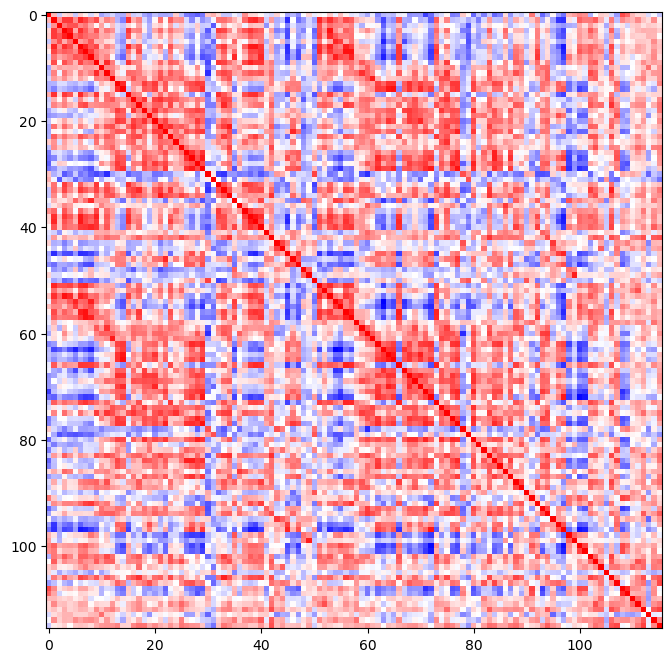

In [37]:
test_file = fc_files[1282]
print(test_file)
test_mat = loadmat(test_file)
fc_emp = test_mat['ROI_activity']
fc_emp = fc_emp / np.max(fc_emp)

fc_emp = np.corrcoef(fc_emp)
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.imshow(fc_emp, cmap='bwr')

In [44]:
# Get the FC data as numpy arrays
dim_x = len(adsp_df_filtered['FC_DATA'])
features = np.zeros(shape=(dim_x, 116, 200))

for i, file in enumerate(adsp_df_filtered['FC_DATA'].values[:100]):
    arr = loadmat(file)['ROI_activity']
    if arr.shape[1] != 200:
        # add padding to get a constant shape
        diff = 200 - arr.shape[1]
        pad_width = ((0, 0), (0, diff))  
        padded_array = np.pad(arr, pad_width, mode='constant', constant_values=0)
    features[i] = padded_array
features.shape

(1353, 116, 200)

In [45]:
y = adsp_df_filtered[['PHC_MEM', 'PHC_EXF', 'PHC_LAN', 'PHC_VSP']]
y.head()

,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP
10,1.377,-0.092,0.666,0.963
91,0.902,0.579,0.757,0.264
92,0.484,0.667,0.956,0.963
119,0.645,0.525,0.448,-0.041
132,1.134,0.149,1.011,0.264


In [46]:
# split into test + training (80% train, 20% test)
features_2d = features.reshape(features.shape[0], -1)
x_train, x_test, y_train, y_test = train_test_split(features_2d, y, test_size = 0.2, random_state = 28)

## Random Forrest Method
Prediction not differentiable wrt to input - need a model per composite (memory, executive function, language and visuospatial)

In [95]:
# split targets into the different composites

# y_train_mem, y_train_exf, y_train_lan, y_train_vsp = y_train['PHC_MEM'], y_train['PHC_EXF'], y_train['PHC_LAN'], y_train['PHC_VSP']
# y_test_mem, y_test_exf, y_test_lan, y_test_vsp = y_test['PHC_MEM'], y_test['PHC_EXF'], y_test['PHC_LAN'], y_test['PHC_VSP']

#### Memory Model

In [99]:
# MEMORY MODEL
# Remove NaNs in target
y_train_mem = y_train['PHC_MEM'].reset_index(drop=True)
y_test_mem = y_test_mem.reset_index(drop=True)

nan_indices = y_train_mem.index[y_train_mem.isna()]
y_train_mem = y_train_mem.drop(nan_indices)
x_train_mem = np.delete(x_train, nan_indices, axis = 0)

# print(nan_indices)
nan_indices_test = y_test_mem.index[y_test_mem.isna()]
y_test_mem = y_test_mem.drop(nan_indices_test)
x_test_mem = np.delete(x_test, nan_indices_test, axis = 0)

In [ ]:
# Initializing the Random Forest Regression model with 10 decision trees
model_mem = RandomForestRegressor(n_estimators = 100, random_state = 5)

# Fitting the Random Forest Regression model to the data
model_mem.fit(x_train_mem, y_train_mem)

In [97]:
# x_test_mem.shape
# Predicting the target values of the test set
y_pred_mem = model_mem.predict(x_test_mem)

# # RMSE (Root Mean Square Error)
# rmse_mem = float(format(np.sqrt(mean_squared_error(y_test_mem, y_pred_mem)), '.3f'))
# print("\nRMSE (MEM): ", rmse_mem)

# compute r^2

In [98]:
from sklearn.metrics import r2_score
r2_mem = r2_score(y_test_mem, y_pred_mem)
print("R2 (MEM): ", r2_mem)

R2 (MEM):  0.011488029551196544


## SVM Method
Prediction differentiable wrt to input